## Question 2.3

Use the provided network layer to carry out Facial Keypoints Detection task. In this task, the model needs to input an image and output a vector containing the coordinates of each keypoint. Typically, the length of this vector is equal to the number of keypoints in the image. Follow the instructions below to complete this task. The data and the model needed for the task are in the 2_3 folder.

# Imports

In [2]:
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# Read in the training and testing set

In [3]:
# Load training data
trainset = pd.read_csv("train.csv")

# Load testing data
testset = pd.read_csv("test.csv")

print("Training data shape:", trainset.shape)
print("Testing data shape:", testset.shape)


Training data shape: (100, 31)
Testing data shape: (25, 31)


In [4]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        # Retrieve the image data from the DataFrame at the specified index
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ').astype(np.float32)
        
        # Reshape the flattened image data into a 2D array (96x96) and normalize pixel values to the range [0, 1]
        image = image.reshape(96, 96) / 255.0
        
        # Add a channel dimension to the image array to match the expected input shape of the neural network
        image = np.expand_dims(image, axis=0)
        
        # Retrieve the keypoints data (x, y coordinates) from the DataFrame at the specified index
        keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        
        # Convert the image and keypoints data into PyTorch tensors and return them as a tuple
        return torch.tensor(image), torch.tensor(keypoints)


# Create datasets
train_dataset = FacialKeypointsDataset(trainset)
test_dataset = FacialKeypointsDataset(testset)

print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))


Training dataset size: 100
Testing dataset size: 25


In [5]:
# Define batch size
batch_size = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Restrucute my previous classifier to form the Nimish Net

In [6]:
class FacialKeypointDetector(nn.Module):
    def __init__(self):
        super(FacialKeypointDetector, self).__init__()
        
        # First level
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)
        
        # Second level
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.2)
        
        # Third level
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.3)
        
        # Fourth level
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.4)
        
        # Final fully connected layers for regression
        self.fc1 = nn.Linear(256 * 6 * 6, 1000)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1000, 1000)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(p=0.6)
        self.fc3 = nn.Linear(1000, 30)  # 30 output channels for 15 facial keypoints (x, y)
        
    def forward(self, x):
        # First level
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        # Second level
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        # Third level
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        # Fourth level
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        x = self.relu6(x)
        x = self.dropout6(x)
        x = self.fc3(x)
        
        return x

# Create an instance of the model
model = FacialKeypointDetector()
print(model)


FacialKeypointDetector(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=9216, out_features=1000, bias=True

# Training

In [7]:
def train_model(model, train_loader, num_epochs=10, lr=0.001):
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Using Mean Squared Error Loss for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track training loss for plotting
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        
        # Shuffle the training data
        train_loader.dataset.dataframe = train_loader.dataset.dataframe.sample(frac=1).reset_index(drop=True)
        
        running_loss = 0.0
        for images, keypoints in train_loader:

            images, keypoints = images, keypoints
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, keypoints)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item() * images.size(0)
        
        # Calculate average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Plot training progress
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.savefig('FKP_process_lr_batch_modified.png')
    plt.show()

Epoch [1/10], Loss: 81908.8735
Epoch [2/10], Loss: 2562.1456
Epoch [3/10], Loss: 2574.8657
Epoch [4/10], Loss: 2507.0778
Epoch [5/10], Loss: 1548.2225
Epoch [6/10], Loss: 551.7898
Epoch [7/10], Loss: 381.3967
Epoch [8/10], Loss: 445.9582
Epoch [9/10], Loss: 432.7810
Epoch [10/10], Loss: 321.9320


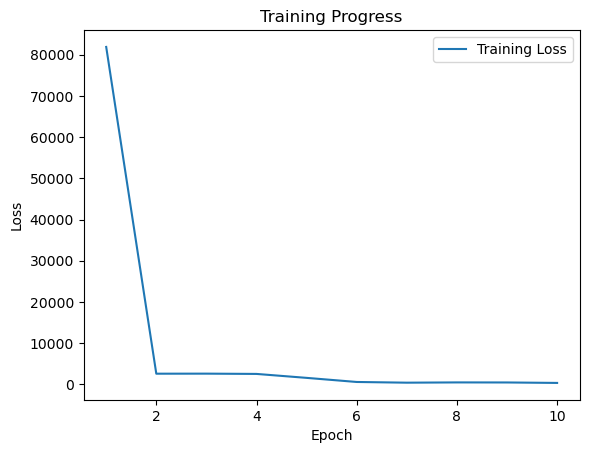

In [8]:
# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FacialKeypointDetector().to(device) 
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
train_model(model, train_loader, num_epochs=10, lr=0.01)

# Save the model

In [9]:
# Define path
PATH = '2-3_FKD.pth'

# Save the model
torch.save(model.state_dict(), PATH)

# Test and plot image

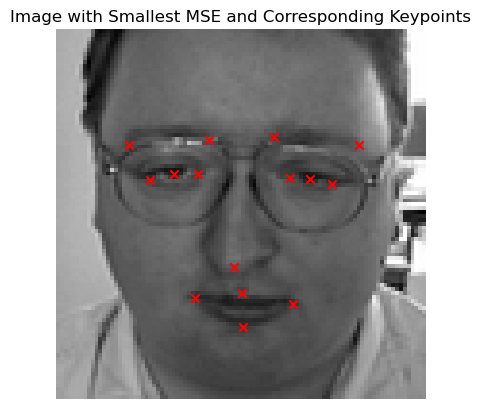

In [10]:
# Load the saved model
model = FacialKeypointDetector()
model.load_state_dict(torch.load('2-3_FKD.pth'))
model.eval()  # Set the model to evaluation mode

# Define a function to calculate mean squared error (MSE)
def calculate_mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

# Evaluate the model on the test data
mse_values = []
with torch.no_grad():
    
    for images, keypoints in test_loader:
        # Forward pass
        outputs = model(images)
        
        # Convert predictions and targets to numpy arrays
        predictions = outputs.cpu().numpy()
        targets = keypoints.cpu().numpy()
        
        # Calculate MSE for each test data
        mse = calculate_mse(predictions, targets)
        mse_values.append(mse)

# Find the index of the test data with the smallest MSE
min_mse_index = np.argmin(mse_values)

# Get the image and corresponding keypoints with the smallest MSE
min_mse_image, min_mse_keypoints = test_dataset[min_mse_index]
min_mse_image = min_mse_image.numpy().squeeze()  # Remove the batch dimension
min_mse_keypoints = min_mse_keypoints.numpy()

# Plot the image with corresponding keypoints
plt.imshow(min_mse_image, cmap='gray')
plt.scatter(min_mse_keypoints[0::2], min_mse_keypoints[1::2], c='red', marker='x')
plt.title('Image with Smallest MSE and Corresponding Keypoints')
plt.axis('off')

# Save the plot as 2-3_img.png
plt.savefig('2-3_img.png')
plt.show()
